In [13]:
import pandas as pd
# import conllu # This doesn't work. This conll file is not conllu
import spacy
from collections import Counter

In [15]:
def extract_data(filename):
    """
    This function is to read the conll file (not readable by conllu)
    :param filename: full name of the conll file
    :return: an array of documents
    """
    sentences = []
    # Open the conll file
    with open(filename, encoding="utf8") as file:
        # Array to store sentence data
        sentence = []
        # Read the file line by line
        for line in file.readlines():
            # The blank line is to separate the documents
            if line != "\n":
                if line[0] == "#":
                    continue
                # Order: tok tok sym sem cat
                token = line.split("\t")
                # Merge the token into the sentence
                sentence.append(token)
            else:
                # Document break found, save the document data
                sentences.append(sentence)
                # Refresh the var for new document
                sentence = []
    return sentences


def get_pos_sem_tag(filename, pipeline):
    """
    This function is to get the POS tags using Spacy and the SEM tag provided in the coNLL file.
    Write the result in a csv file
    :param filename: name of the coNLL file
    :param pipeline: spacy pipeline. Make sure you install it using `python -m spacy download <pipeline name>`
    :return: number of records
    """
    pipeline = spacy.load(pipeline)
    data = extract_data(filename)
    # Tokens for each doc
    tokens = []
    # POS tags for each doc
    poss = []
    # SEM tags for each dog
    sems = []
    # Loop over the data retrieved from the CONLL file
    for item in data:
        # Tokens for getting POS tags using spacy
        token = " ".join([e[0] for e in item])
        # Process the tokens
        minidoc = pipeline(token)
        # Get spacy POS tags
        pos_tags = [token.pos_ for token in minidoc]
        # Get provided SEM tags
        sem_tags = [e[3] for e in item]
        # Convert tag list to string and put in the list
        poss.append(" ".join(pos_tags))
        sems.append(" ".join(sem_tags))
        # Save the corresponding token
        tokens.append(token)
    # Export CSV
    minidf = pd.DataFrame()
    minidf["pos"] = poss
    minidf["sem"] = sems
    minidf["tok"] = tokens
    minidf.to_csv(filename + ".tsv", sep="\t", encoding="utf8", index=False)
    return len(poss)

def pre_process_spacy_pos_NE(pos_tags):
    """
    This function is to pre process the Spacy POS tags.
    To merge the consecutive PROPN tags into one
    :param pos_tags: list of POS tags
    :return: processed list of POS tags
    """
    results = []
    # Loop over the POS tags
    for i in range(len(pos_tags)):
        # Not further processing the unintended tags
        if pos_tags[i] != "PROPN" and pos_tags[i] != "X":
            results.append(pos_tags[i])
        # Aim at the PROPN tag
        if pos_tags[i] == "PROPN":
            try:
                # Check if the preceding tag is intended
                if pos_tags[i-1] != "PROPN" and pos_tags[i-1] != "X":
                    results.append(pos_tags[i])
                # Ignore the next PROPN or X tags if this one is already PROPN
                if pos_tags[i+1] == "PROPN" and pos_tags[i] == "X":
                    continue
            except IndexError:
                # Handling the Index Error
                continue
    return results


def get_pos_sem_pairs(tsv_filename):
    """
    Get POS-SEM tag pairs
    """
    minidf = pd.read_csv(tsv_filename, sep="\t")
    outputdf = pd.DataFrame()
    pos_sem_pairs = list()
    # Loop over the data frame
    for index, value in minidf.iterrows():
        # Extract record info of POS tags and SEM tags (and tokens as well)
        pos = value["pos"].split(" ")
        pos = pre_process_spacy_pos_NE(pos)
        sem = value["sem"].split(" ")
        tok = value["tok"]
        # Ignore the non-aligned pairs
        if len(pos) != len(sem):
            continue
        for i in range(len(pos)):
            # Get the POS-SEM pair
            ptag = pos[i]
            stag = sem[i]
            pair = (ptag,stag)
            # print(pair)
            pos_sem_pairs.append(pair)
    return pos_sem_pairs

def get_unique_tags(tsv_filename):
    """
    Get POS-SEM tags
    """
    minidf = pd.read_csv(tsv_filename, sep="\t")
    outputdf = pd.DataFrame()
    pos_tags = set()
    sem_tags = set()
    # Loop over the data frame
    for index, value in minidf.iterrows():
        # Extract record info of POS tags and SEM tags (and tokens as well)
        pos = value["pos"].split(" ")
        pos = pre_process_spacy_pos_NE(pos)
        sem = value["sem"].split(" ")
        tok = value["tok"]
        # Ignore the non-aligned pairs
        if len(pos) != len(sem):
            continue
        for i in range(len(pos)):
            # Get the POS-SEM pair
            ptag = pos[i]
            stag = sem[i]
            # print(pair)
            pos_tags.add(ptag)
            sem_tags.add(stag)
    return pos_tags, sem_tags

In [37]:
chosen_lang = "nl"
languages = {"de":"de/train.tsv","it":"it/train.tsv","en":"en/train.tsv","nl":"nl/train.tsv"}
choice = languages[chosen_lang]

In [38]:
pos_sem_pairs = get_pos_sem_pairs(choice)
pos_tags, sem_tags = get_unique_tags(choice)
#pos_sem_pairs

In [39]:
pair_occurrences = Counter(pos_sem_pairs) # counting how many times each pair occurs
#dict(sorted(pair_occurrences.items(), key=lambda item: item[1]))

In [40]:
# creating the dataframe of frequencies
df = pd.DataFrame(columns=pos_tags, index=sem_tags).fillna(0)
for (ptag,stag),frequency in pair_occurrences.items():
    df[ptag][stag]=int(frequency)

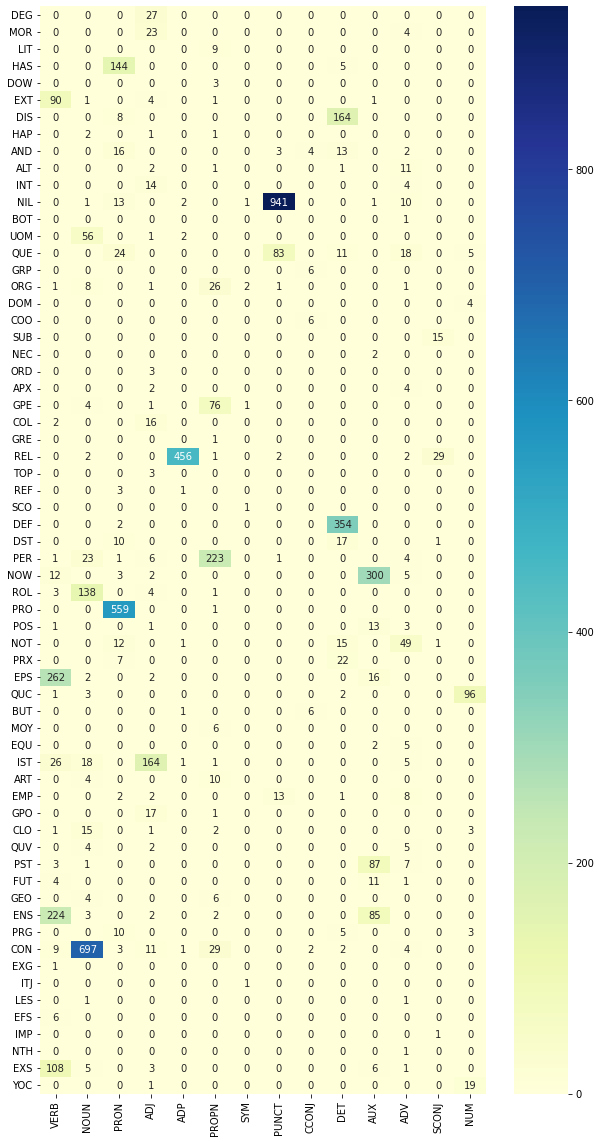

<Figure size 432x288 with 0 Axes>

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,20))
ax = sns.heatmap(df, cmap="YlGnBu", annot=True, fmt="d")
plt.show()
plt.savefig("heatmaps/" + chosen_lang + ".png")